In [1]:
import os
import sys
sys.path.append(os.getcwd())

import restools
from comsdk.research import Research

import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd

In [2]:
from pyESN import ESN, optimal_esn
from skesn.esn import EsnForecaster

In [3]:
res = Research.open('RC_MOEHLIS')
task_num = 42

data = []
time = []
n_files = 100

for num_data in range(n_files):
    with open(os.path.join(res.get_task_path(task_num), str(num_data+1)), 'rb') as a:
        b = pickle.load(a)
    data.append(b['timeseries'])
    time.append(b['time'])


Loaded research at C:\Users\ovann\Documents\Researches\2021-04-30-predicting-transition-to-turbulence-using-esn
Number of tasks in the current research: 5059


In [4]:
df_time_len = pd.DataFrame(
    {
        'time_len': [len(i) for i in time],
        'file_name': [i+1 for i in range(n_files)]
    })

df_time_len.sort_values(by=['time_len'], inplace=True)

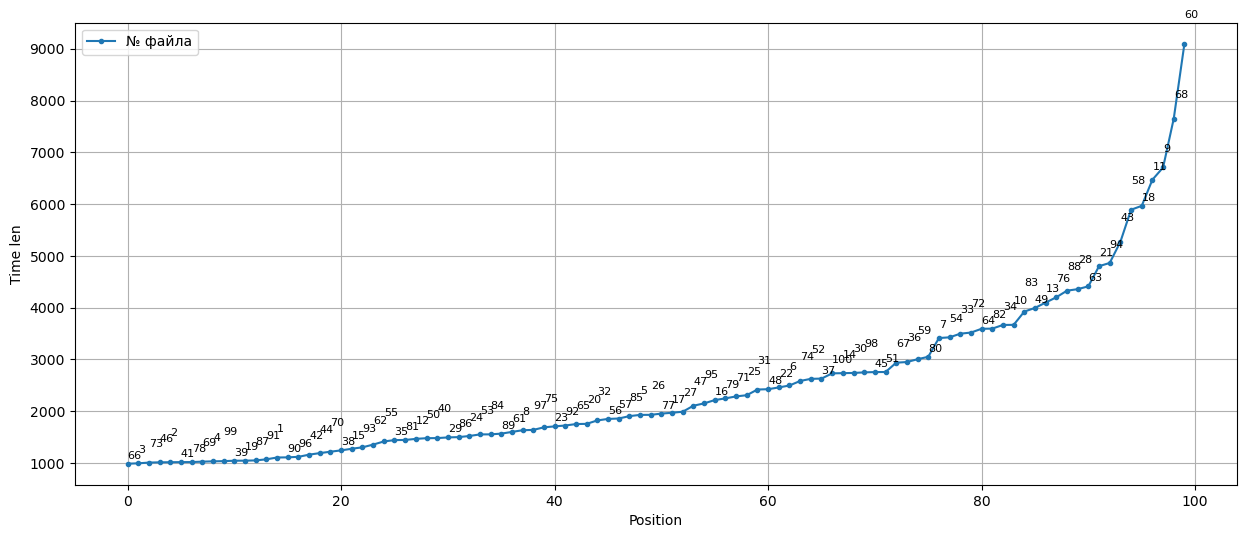

In [22]:
plt.figure(figsize=(15,6))
plt.plot(range(n_files), df_time_len.time_len, '.-', label='№ файла')
for i, j, k in zip(df_time_len.time_len, df_time_len.file_name, range(n_files)):
    plt.text(k, i+100+(k%5)*100, j, fontsize=8.)
plt.grid()
plt.ylabel('Time len')
plt.xlabel('Position')
plt.legend()

In [55]:
n = 60 - 1
datalen = len(time[n])
trainlen = int(len(time[n])*0.8)
testlen = datalen - trainlen

training_timeseries = data[n][:trainlen]
test_timeseries_set = [data[n][trainlen:]]

In [56]:
spectral_radius_values = [0.5]
sparsity_values = [0.9]

esn, errors = optimal_esn(
    training_timeseries, 
    test_timeseries_set, 
    spectral_radius_values=spectral_radius_values, 
    sparsity_values=sparsity_values,
    n_reservoir=1500, 
    return_errors=True, 
    random_seed_starts_at=42, 
    trial_number=1
)

Spectral radius = 0.5
	Sparsity = 0.9
		Trial #42
			New best ESN. Error = 0.1986713536270348, spectral radius = 0.5, sparsity = 0.9


In [57]:
model = EsnForecaster(
    n_reservoir=1500,
    spectral_radius=spectral_radius_values[0],
    sparsity=sparsity_values[0],
    regularization='noise',
    lambda_r=0.001,
    random_state=42
)

model.fit(training_timeseries);

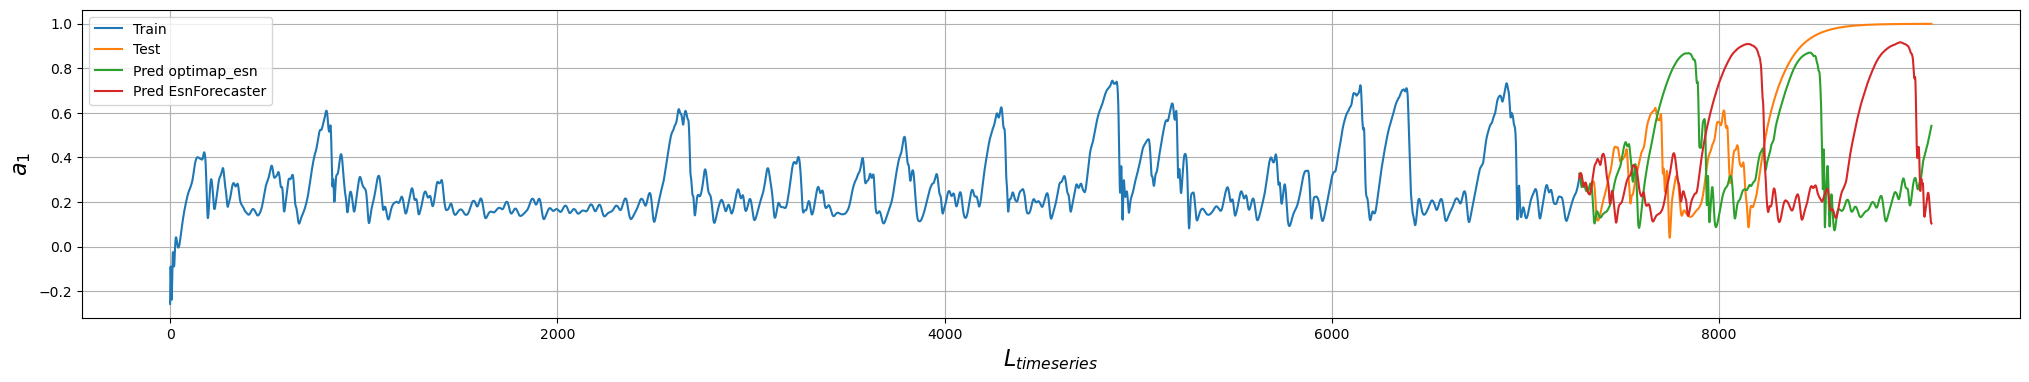

In [58]:
N = 1

plt.figure(figsize=(25,4*N))

for i in range(N):
    plt.subplot(N,1,i+1)
    
    plt.plot(time[n][:trainlen], training_timeseries[:, i], label='Train')
    plt.plot(time[n][trainlen:], test_timeseries_set[0][:, i], label='Test')
    plt.plot(time[n][trainlen:], esn.predict(np.ones(testlen))[:, i], label='Pred optimap_esn')
    plt.plot(time[n][trainlen:], model.predict(testlen)[:, i], label='Pred EsnForecaster')

    plt.xlabel(r'$L_{timeseries}$', fontsize=16)
    plt.ylabel(fr'$a_{i+1}$', fontsize=16)
    
    plt.legend()
    plt.grid()

In [59]:
n = 66 - 1
datalen = len(time[n])
trainlen = int(len(time[n])*0.8)
testlen = datalen - trainlen

training_timeseries = data[n][:trainlen]
test_timeseries_set = [data[n][trainlen:]]

In [60]:
spectral_radius_values = [0.5]
sparsity_values = [0.9]

esn, errors = optimal_esn(
    training_timeseries, 
    test_timeseries_set, 
    spectral_radius_values=spectral_radius_values, 
    sparsity_values=sparsity_values,
    n_reservoir=1500, 
    return_errors=True, 
    random_seed_starts_at=42, 
    trial_number=1
)

Spectral radius = 0.5
	Sparsity = 0.9
		Trial #42
			New best ESN. Error = 0.00033484383445307405, spectral radius = 0.5, sparsity = 0.9


In [61]:
model = EsnForecaster(
    n_reservoir=1500,
    spectral_radius=spectral_radius_values[0],
    sparsity=sparsity_values[0],
    regularization='noise',
    lambda_r=0.001,
    use_bias=True,
    random_state=42
)

model.fit(training_timeseries);

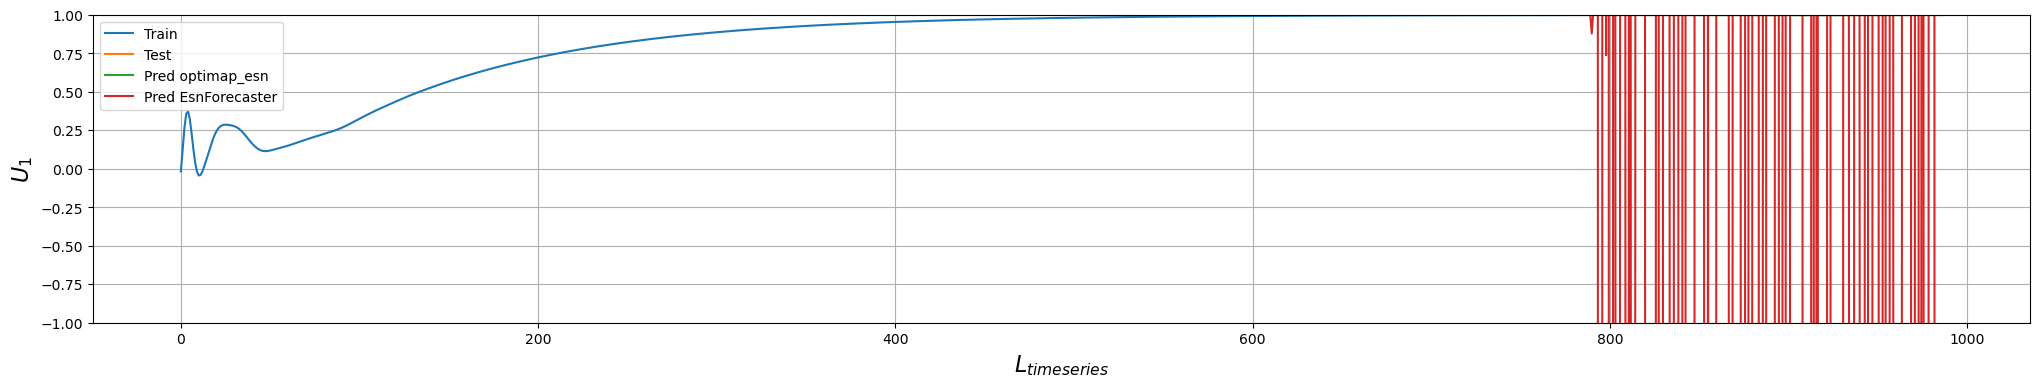

In [62]:
N = 1

plt.figure(figsize=(25,4*N))

for i in range(N):
    plt.subplot(N,1,i+1)
    
    plt.plot(time[n][:trainlen], training_timeseries[:, i], label='Train')
    plt.plot(time[n][trainlen:], test_timeseries_set[0][:, i], label='Test')
    plt.plot(time[n][trainlen:], esn.predict(np.ones(testlen))[:, i], label='Pred optimap_esn')
    plt.plot(time[n][trainlen:], model.predict(testlen)[:, i], label='Pred EsnForecaster')

    plt.xlabel(r'$L_{timeseries}$', fontsize=16)
    plt.ylabel(fr'$a_{i+1}$', fontsize=16)
    
    plt.ylim(-1,1)
    plt.legend()
    plt.grid()

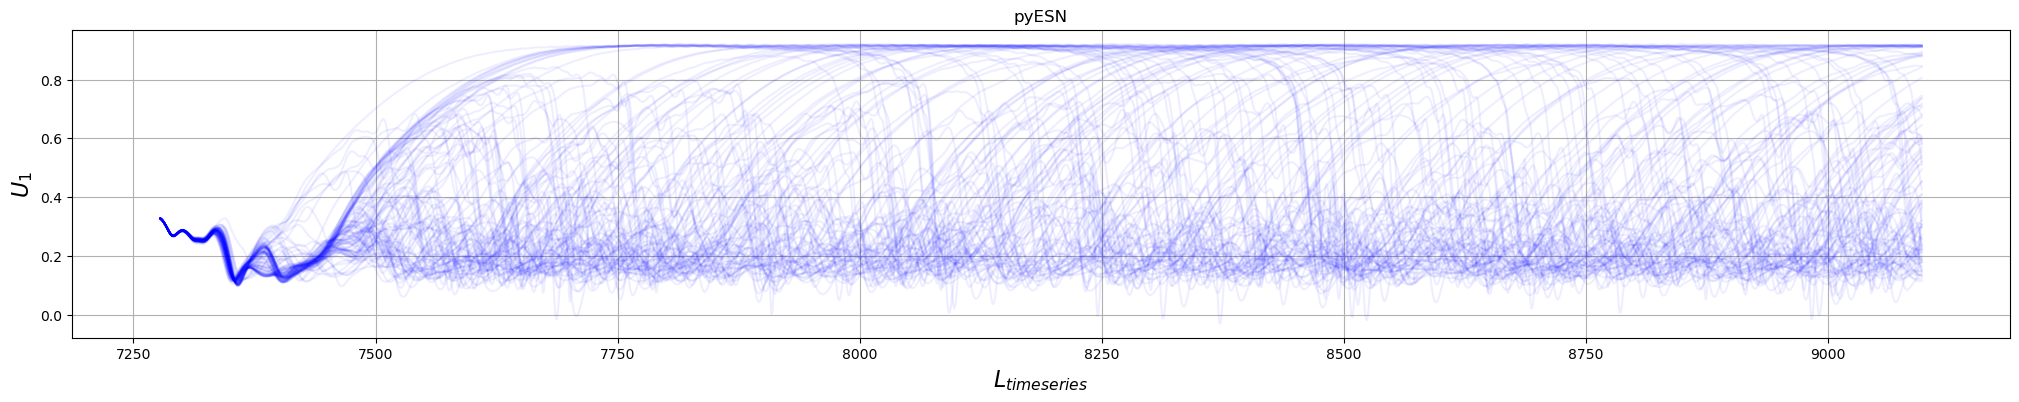

In [34]:
N = 1

plt.figure(figsize=(25,4*N))
plt.title('pyESN')
for j in range(100):
    pred = esn.predict(np.ones(testlen))
    for i in range(N):
        plt.subplot(N,1,i+1)
        
        plt.plot(time[n][trainlen:], pred[:, i], color='#0000FF11')

        plt.xlabel(r'$L_{timeseries}$', fontsize=16)
        plt.ylabel(fr'$U_{i+1}$', fontsize=16)
        
plt.grid()

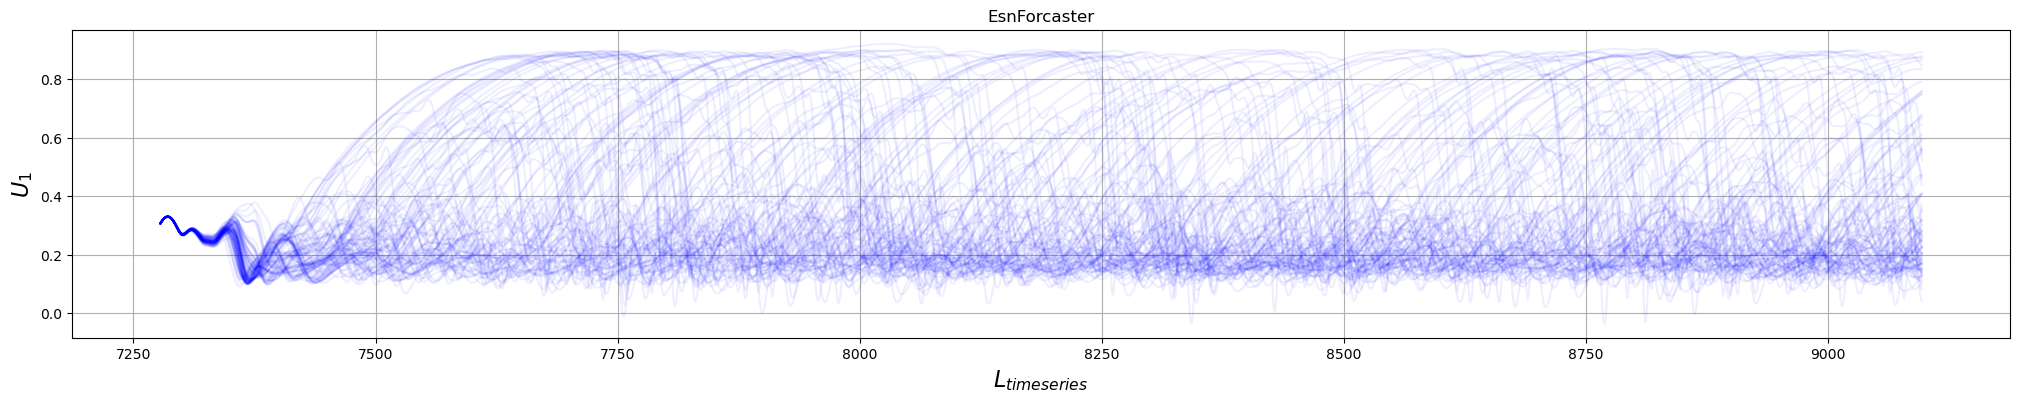

In [35]:
N = 1

plt.figure(figsize=(25,4*N))
plt.title('EsnForcaster')
for j in range(100):
    pred = model.predict(testlen)
    for i in range(N):
        plt.subplot(N,1,i+1)
        
        plt.plot(time[n][trainlen:], pred[:, i], color='#0000FF11')

        plt.xlabel(r'$L_{timeseries}$', fontsize=16)
        plt.ylabel(fr'$U_{i+1}$', fontsize=16)
        
plt.grid()

In [54]:
%%time
error_min_set = []
len_set = []

for i in range(n_files):
    n = i
    datalen = len(time[n])
    trainlen = int(len(time[n])*0.8)
    testlen = datalen - trainlen

    training_timeseries = data[n][:trainlen]
    test_timeseries_set = [data[n][trainlen:]]

    spectral_radius_values = [0.5]
    sparsity_values = [0.1]

    esn, errors = optimal_esn(
        training_timeseries, 
        test_timeseries_set, 
        spectral_radius_values=spectral_radius_values, 
        sparsity_values=sparsity_values,
        n_reservoir=1500, 
        return_errors=True, 
        random_seed_starts_at=42, 
        trial_number=1
    )
    
    error_min_set.append(min(errors[0][0]))
    len_set.append(datalen)

Spectral radius = 0.5
	Sparsity = 0.1
		Trial #42
			New best ESN. Error = 0.0006202193734284179, spectral radius = 0.5, sparsity = 0.1
Spectral radius = 0.5
	Sparsity = 0.1
		Trial #42
			New best ESN. Error = 0.000262190209351726, spectral radius = 0.5, sparsity = 0.1
Spectral radius = 0.5
	Sparsity = 0.1
		Trial #42
			New best ESN. Error = 0.0004608146736561428, spectral radius = 0.5, sparsity = 0.1
Spectral radius = 0.5
	Sparsity = 0.1
		Trial #42
			New best ESN. Error = 0.0004401365562133297, spectral radius = 0.5, sparsity = 0.1
Spectral radius = 0.5
	Sparsity = 0.1
		Trial #42
			New best ESN. Error = 1.2663797681461282, spectral radius = 0.5, sparsity = 0.1
Spectral radius = 0.5
	Sparsity = 0.1
		Trial #42
			New best ESN. Error = 0.0037058478362017445, spectral radius = 0.5, sparsity = 0.1
Spectral radius = 0.5
	Sparsity = 0.1
		Trial #42
			New best ESN. Error = 0.004644647341333564, spectral radius = 0.5, sparsity = 0.1
Spectral radius = 0.5
	Sparsity = 0.1
		Trial #42
			

In [56]:
%%time
error_min_set1 = []

for i in range(n_files):
    n = i
    datalen = len(time[n])
    trainlen = int(len(time[n])*0.8)
    testlen = datalen - trainlen
    
    training_timeseries = data[n][:trainlen]
    test_timeseries_set = [data[n][trainlen:]]

    model = EsnForecaster(
        n_reservoir=1500,
        spectral_radius=spectral_radius_values[0],
        sparsity=sparsity_values[0],
        regularization='noise',
        lambda_r=0.001,
        use_bias=True,
        random_state=42
        )
        
    model.fit(training_timeseries)
    error_min_set1.append(
        np.sqrt(np.mean((model.predict(test_timeseries_set[0].shape[0]) - test_timeseries_set)**2))
    )

CPU times: total: 24min 46s
Wall time: 4min 10s


In [57]:
df = pd.DataFrame(
    {
        'n_file': [i+1 for i in range(n_files)],
        'len':len_set, 
        'Loss_pyESN': error_min_set,
        'Loss_EsnForecaster':error_min_set1
    }
)

df = df.sort_values(by=['len'])

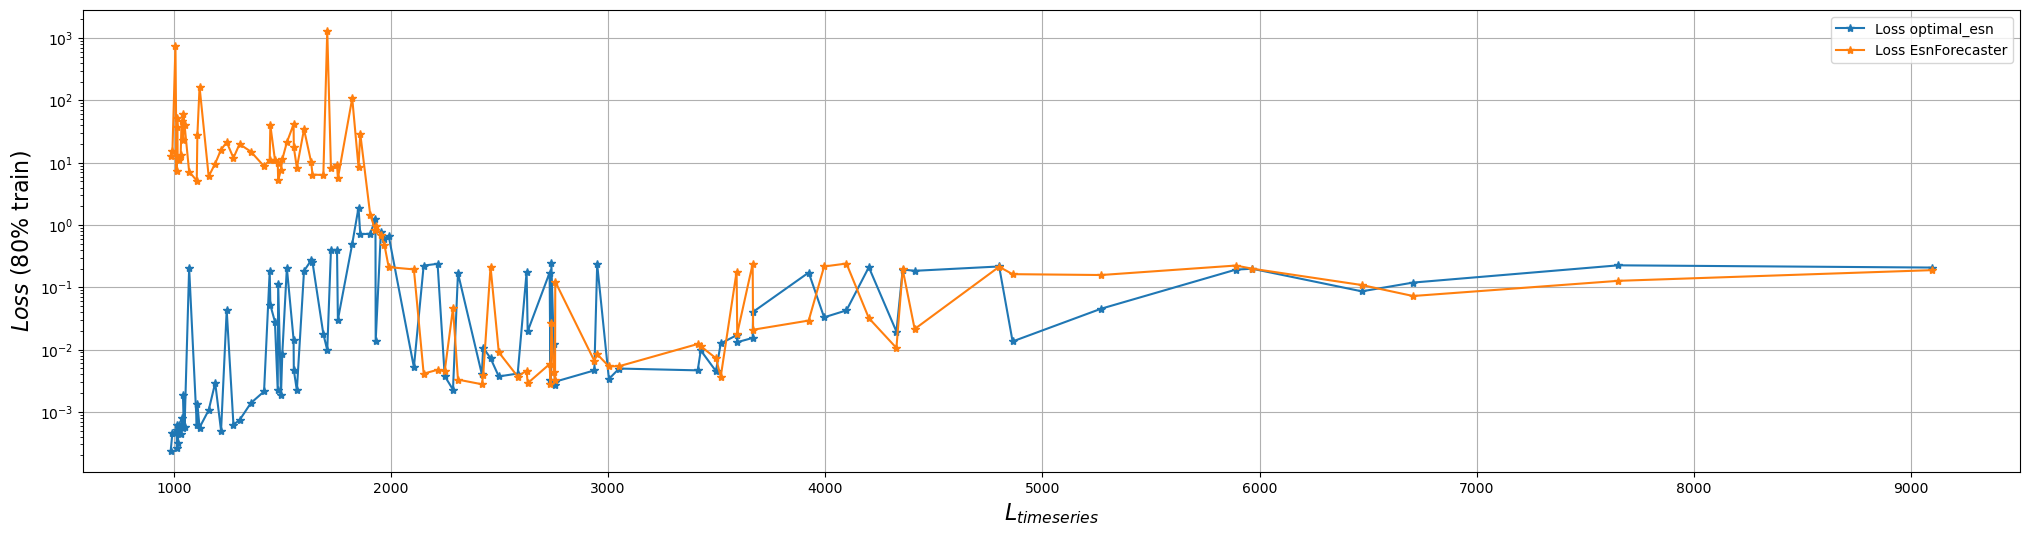

In [59]:
plt.figure(figsize=(25,6))
plt.plot(df.len, df.Loss_pyESN, '*-', label='Loss optimal_esn')
plt.plot(df.len, df.Loss_EsnForecaster, '*-', label='Loss EsnForecaster')

plt.semilogy();
plt.xlabel(r'$L_{timeseries}$', fontsize=16)
plt.ylabel(f'$Loss$ (80% train)', fontsize=16)
plt.legend()
plt.grid()